In [1]:
# Francisco Dominguez Mateos
# 24/06/2020
#From:https://roberttlange.github.io/posts/2020/03/blog-post-10/

In [56]:
#!conda install -c conda-forge matplotlib --yes
#!conda install -c pytorch pytorch --yes
#!conda install -c pytorch torchvision --yes
#!conda install -c anaconda seaborn --yes

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

In [6]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time
#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples
from helpers import plot_mnist_performance


In [7]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [9]:
# Generate a random matrix
x = random.uniform(key, (1000, 1000))
# Compare running times of 3 different matrix multiplications
%time y = onp.dot(x, x)
%time y = np.dot(x, x)
%time y = np.dot(x, x).block_until_ready()

CPU times: user 100 ms, sys: 44 ms, total: 144 ms
Wall time: 30.2 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 535 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 739 µs


In [10]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

In [13]:
%time out = ReLU(x).block_until_ready()
# Call jitted version to compile for evaluation time!
%time jit_ReLU(x).block_until_ready()
%time out = jit_ReLU(x).block_until_ready()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 694 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 613 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 408 µs


In [14]:
def FiniteDiffGrad(x):
    """ Compute the finite difference derivative approx for the ReLU"""
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2.0 * 1e-3))

# Compare the Jax gradient with a finite difference approximation
print("Jax Grad: ", jit(grad(jit(ReLU)))(2.))
print("FD Gradient:", FiniteDiffGrad(2.))

Jax Grad:  1.0
FD Gradient: 0.99998707


In [15]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [random.normal(key, (hidden_dim, feature_dim)),
          random.normal(key, (hidden_dim, ))]

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

In [52]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 2000

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

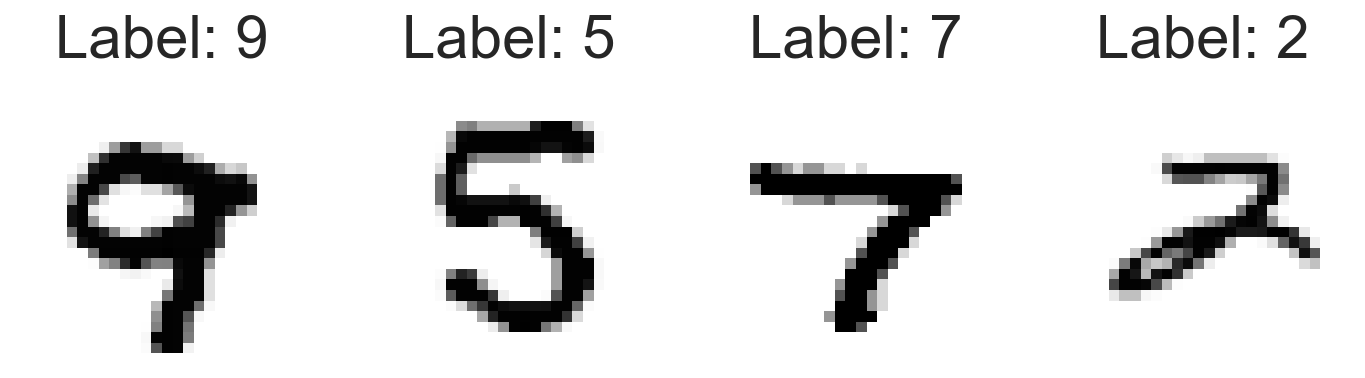

In [53]:
plot_mnist_examples(train_loader)

In [18]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [19]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    # COOL! output here is log(p(nn(in_array))) where nn is the network up to the last layer
    # this is because in the loss we only need to multiply pred*target where pred=logits-logsumexp(logits)
    # a more naive and traditional whould be just release logits
    # but in this case loss is slightly more complicated pred*log(pred) where pred=softmax(logits)
    return logits - logsumexp(logits)

In [20]:
# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [39]:
#@jit
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)
#@jit
def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
#@jit
def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

In [32]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

In [37]:
#@jit
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc  = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return train_loss, log_acc_train, log_acc_test

In [24]:
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

Epoch 1 | T: 9.02 | Train A: 0.974 | Test A: 0.967
Epoch 2 | T: 7.98 | Train A: 0.984 | Test A: 0.974
Epoch 3 | T: 8.08 | Train A: 0.990 | Test A: 0.977
Epoch 4 | T: 8.46 | Train A: 0.994 | Test A: 0.982
Epoch 5 | T: 8.19 | Train A: 0.996 | Test A: 0.982
Epoch 6 | T: 8.11 | Train A: 0.994 | Test A: 0.979
Epoch 7 | T: 7.98 | Train A: 0.996 | Test A: 0.979
Epoch 8 | T: 7.98 | Train A: 0.998 | Test A: 0.982
Epoch 9 | T: 8.02 | Train A: 0.997 | Test A: 0.980
Epoch 10 | T: 8.10 | Train A: 0.998 | Test A: 0.981


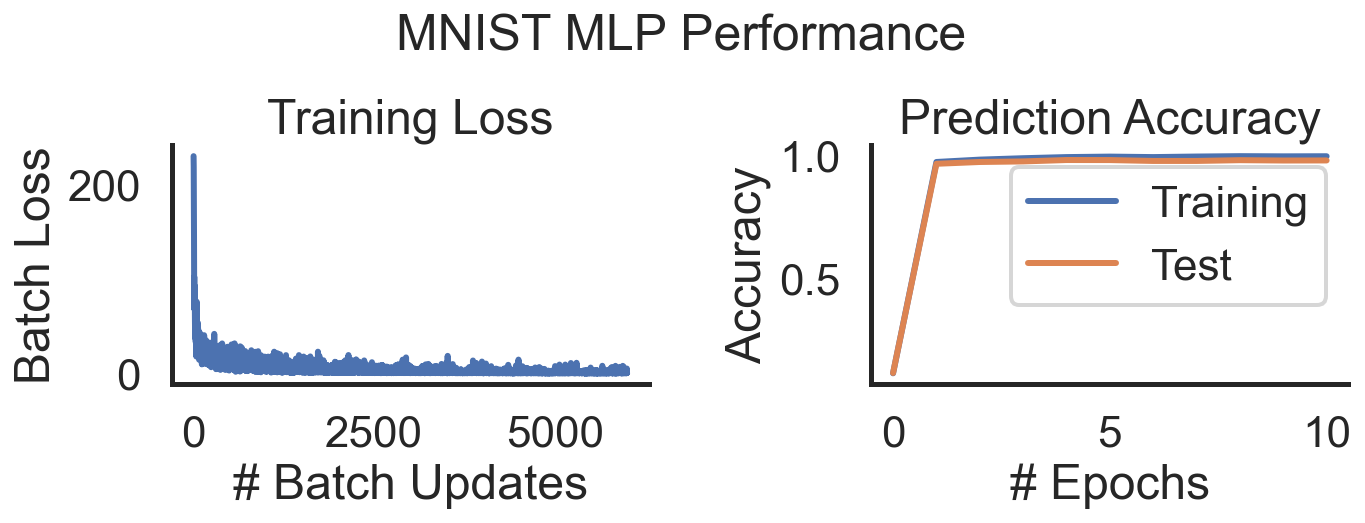

In [25]:
# Plot the loss curve over time
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")

In [26]:
init_fun, conv_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(num_classes),
                                 LogSoftmax)

In [27]:
_, params = init_fun(key, (batch_size, 1, 28, 28))

In [46]:
#@jit
def accuracy(params, data_loader):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(conv_net(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
        break
    return acc_total/len(data_loader.dataset)

@jit
def loss(params, images, targets):
    preds = conv_net(params, images)
    return -np.sum(preds * targets)

In [47]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 10

In [54]:
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="CNN")

Epoch 1 | T: 10.34 | Train A: 0.027 | Test A: 0.160
Epoch 2 | T: 6.80 | Train A: 0.031 | Test A: 0.184
Epoch 3 | T: 6.81 | Train A: 0.032 | Test A: 0.190
Epoch 4 | T: 6.88 | Train A: 0.032 | Test A: 0.191
Epoch 5 | T: 6.87 | Train A: 0.032 | Test A: 0.193
Epoch 6 | T: 6.88 | Train A: 0.033 | Test A: 0.194
Epoch 7 | T: 6.78 | Train A: 0.033 | Test A: 0.193
Epoch 8 | T: 6.80 | Train A: 0.033 | Test A: 0.195
Epoch 9 | T: 6.80 | Train A: 0.033 | Test A: 0.194
Epoch 10 | T: 6.87 | Train A: 0.033 | Test A: 0.195


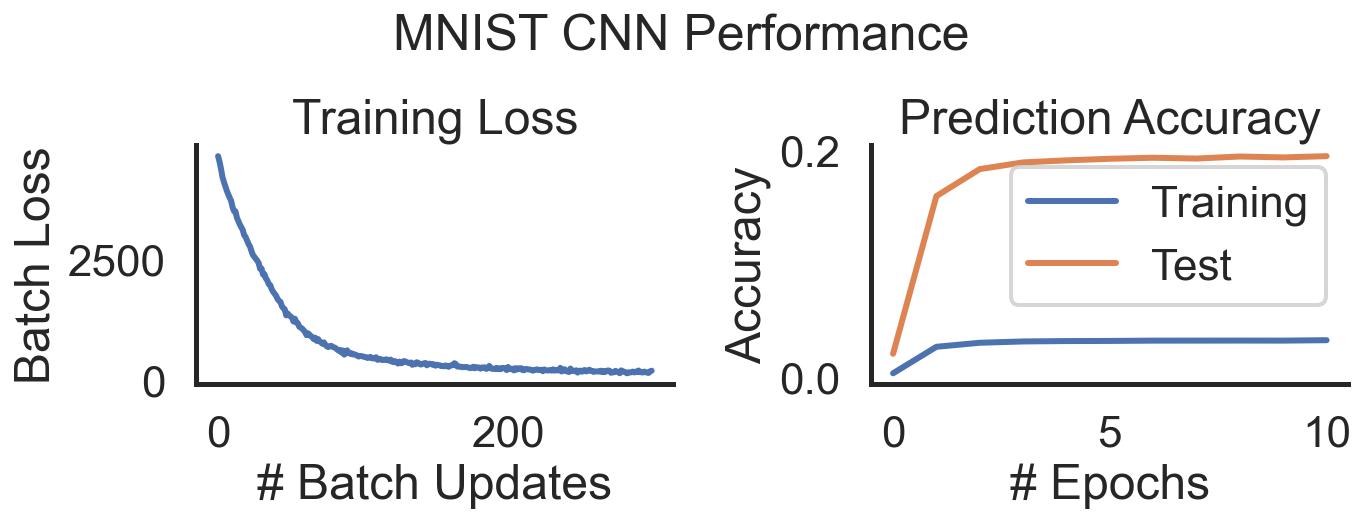

In [55]:
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST CNN Performance")

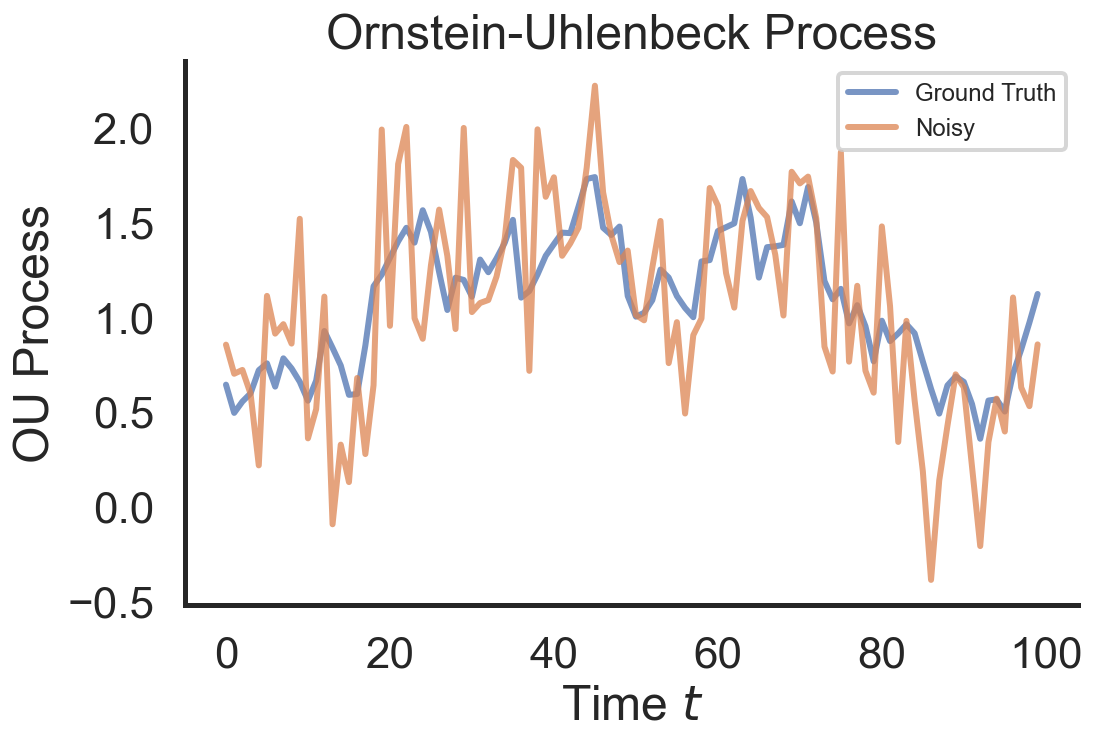

In [34]:
# Generate & plot a time series generated by the OU process
from helpers import generate_ou_process, plot_ou_process
x_0, mu, tau, sigma, dt = 0, 1, 2, 0.5, 0.1
noise_std = 0.1
num_dims, batch_size = 100, 50  # Number of timesteps in process

x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau,
                                 sigma, noise_std, dt)
plot_ou_process(x[0, :], x_tilde[0, :])

In [35]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

In [36]:
def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]

        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W)
                                  + np.dot(np.multiply(reset_gate, hidden), out_U)
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun

In [37]:
num_dims = 10              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 12      # GRU cells in the RNN layer

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                GRU(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    return np.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

In [38]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_batches = 1000

train_loss_log = []
start_time = time.time()
for batch_idx in range(num_batches):
    x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
    x_in = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
    y = np.array(x[:, 1:])
    params, opt_state, loss = update(params, x_in, y, opt_state)
    batch_time = time.time() - start_time
    train_loss_log.append(loss)

    if batch_idx % 100 == 0:
        start_time = time.time()
        print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))

Batch 0 | T: 2.86 | MSE: 0.65 |
Batch 100 | T: 0.18 | MSE: 0.34 |
Batch 200 | T: 0.19 | MSE: 0.24 |
Batch 300 | T: 0.18 | MSE: 0.16 |
Batch 400 | T: 0.18 | MSE: 0.15 |
Batch 500 | T: 0.18 | MSE: 0.12 |
Batch 600 | T: 0.19 | MSE: 0.11 |
Batch 700 | T: 0.19 | MSE: 0.10 |
Batch 800 | T: 0.18 | MSE: 0.12 |
Batch 900 | T: 0.17 | MSE: 0.09 |


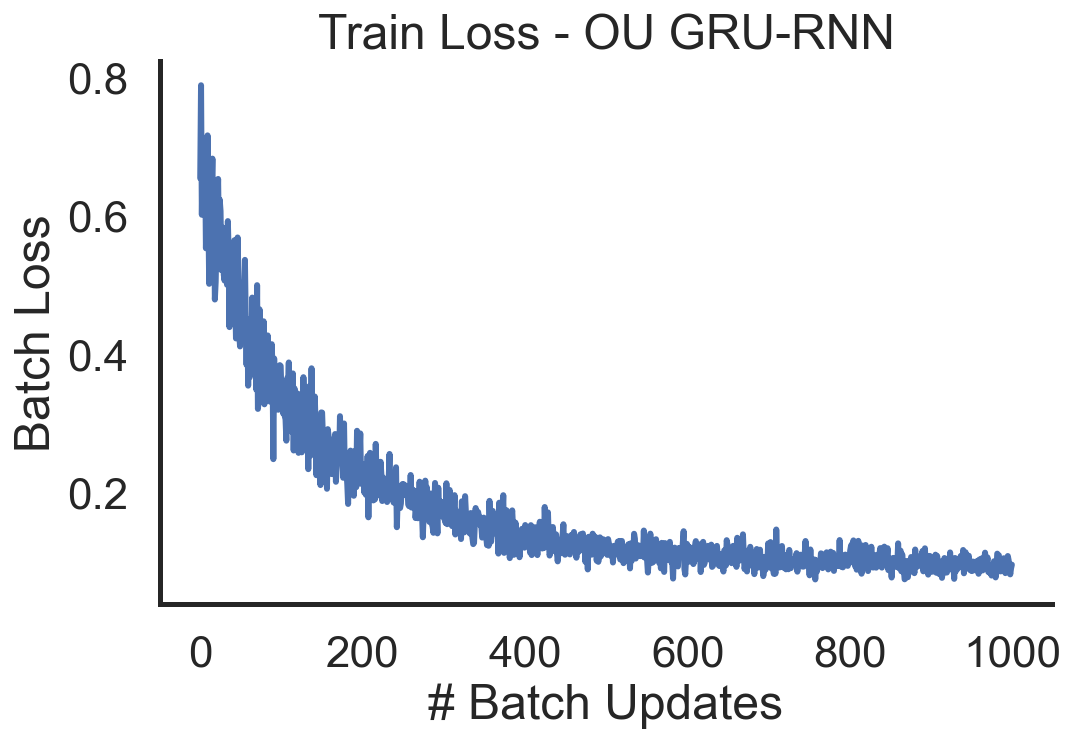

In [39]:
# Plot the training loss for OU-GRU-RNN!
from helpers import plot_ou_loss
plot_ou_loss(train_loss_log)

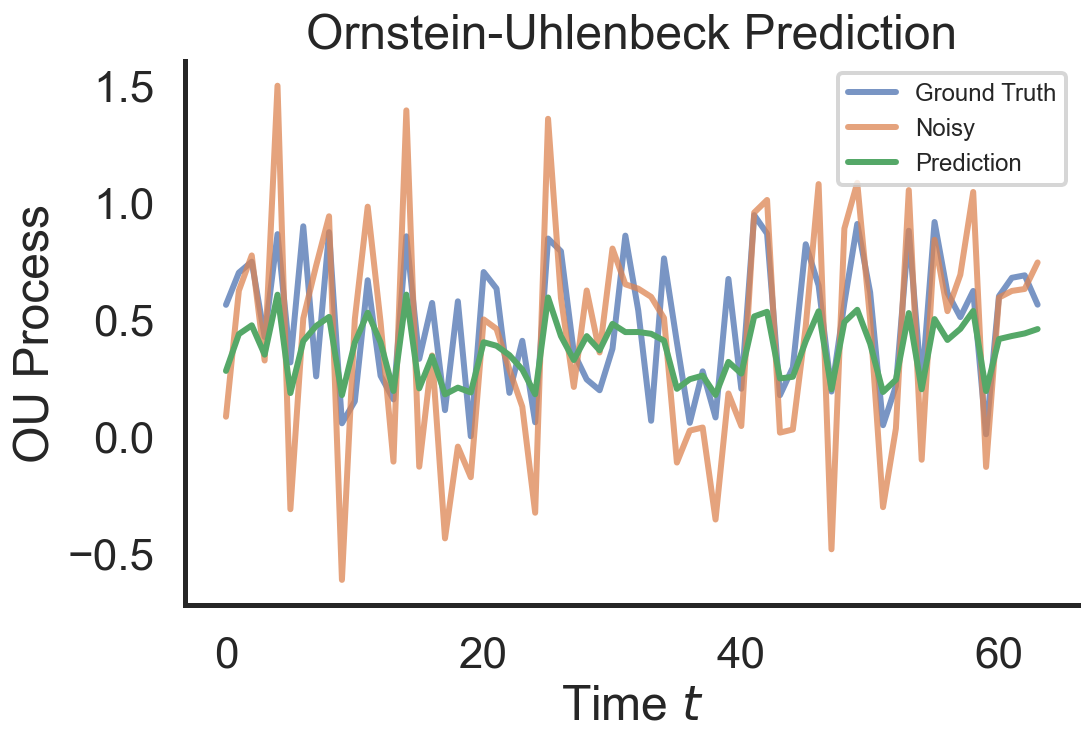

In [40]:
# Plot a prediction and ground truth OU process
x_true, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
x = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
y = np.array(x[:, 1:])
preds = gru_rnn(params, x)

x = onp.array(x)
y = onp.array(y)
x_pred = onp.array(preds)
plot_ou_process(x_true[:, 0], x_tilde=x_tilde[:, 0], x_pred=x_pred[0, :],
               title=r"Ornstein-Uhlenbeck Prediction")